In [14]:
from ortools.linear_solver import pywraplp
import seaborn as sns
import numpy as np 

In [25]:
import time 
class WelfareSolver:
    def __init__(self, n:int, m:int, b:float, v:np.ndarray)->None:
        self.n = n 
        self.m = m 
        self.b = b 

        shape = v.shape
        if(shape[0]!=n and shape[1]!=m):
            raise ValueError("check the valuation profile dimensions")
        
        self.v = v 
        self.solver = pywraplp.Solver.CreateSolver('SCIP')

        if not self.solver: 
            return None 

    def create_vars(self):
        self.assign_vars = []
        self.subsidy_vars = []

        s = time.time()
        for i in range(self.n):
            assign_matrix_row = []
            for j in range(self.m):
                assign_matrix_row.append(self.solver.IntVar(0, 1, f"x_({i}, {j})"))

            self.assign_vars.append(assign_matrix_row)
            self.subsidy_vars.append(self.solver.NumVar(0, self.b, f"p_{i}"))
        e = time.time()

        return e-s 

    def create_assign_constraints(self, j:int):
        s = time.time()
        self.solver.Add(sum([self.assign_vars[i][j] for i in range(self.n)])== 1)
        e = time.time()
        return e-s

    def create_subsidy_constraint(self):
        s = time.time()
        self.solver.Add(sum(self.subsidy_vars)<=self.b)
        for i in range(self.n):
            self.solver.Add(self.subsidy_vars[i]<=1)
        e = time.time()
        return e-s

    def create_envy_constraint(self, i1, i2):
        s = time.time()
        envy = self.subsidy_vars[i1] - self.subsidy_vars[i2] + sum([self.v[i1][j]*self.assign_vars[i1][j] - self.v[i1][j]*self.assign_vars[i2][j] for j in range(self.m)])
        self.solver.Add(envy>=0)
        e = time.time()
        return e-s

    def get_bundle_value(self, i):
        return sum([self.v[i][j] * self.assign_vars[i][j] for j in range(self.m)])

    def create_objective(self):
        s = time.time()
        obj = sum([self.get_bundle_value(i) for i in range(self.n)])
        self.solver.Maximize(obj)
        e = time.time()
        return e-s

    def execute(self):
        if not self.solver:
            return None 

        else:
            t1 = self.create_vars()
            print(f" created modelling variables : {t1} miliseconds elpased")

            s = time.time()
            for i in range(self.n):
                self.create_assign_constraints(i)
            e = time.time()
            print(f" created assignment constraint : {e-s} miliseconds elapsed")

            t3 = self.create_subsidy_constraint()
            print(f" created subsidy constraint : {t3} miliseconds elapsed")

            s = time.time()
            for i in range(self.n):
                for j in range(self.n):
                    if(i!=j):
                        self.create_envy_constraint(i, j)

            e = time.time()
            print(f" created envy constraints : {e-s} miliseconds elapsed")


            t5 = self.create_objective()
            print(f" created objective function : {t5} miliseconds elpased")

            status = self.solver.Solve()

            if status == pywraplp.Solver.OPTIMAL:
                print('optimal welfare value =', self.solver.Objective().Value())

                for i in range(self.n):
                    for j in range(self.m):
                        print(self.assign_vars[i][j].name(), ' = ', self.assign_vars[i][j].solution_value(), end='|')

                    print("")

                for i in range(self.n):
                    print(self.subsidy_vars[i].name(), ' = ', self.subsidy_vars[i].solution_value())

                print('Problem solved in %f milliseconds' % self.solver.wall_time())
                print('Problem solved in %d iterations' % self.solver.iterations())
                print('Problem solved in %d branch-and-bound nodes' % self.solver.nodes())

            else:
                print('The problem does not have an optimal solution.')

 created modelling variables : 0.00011086463928222656 miliseconds elpased
 created assignment constraint : 0.000335693359375 miliseconds elapsed
 created subsidy constraint : 7.104873657226562e-05 miliseconds elapsed
 created envy constraints : 0.024194717407226562 miliseconds elapsed
 created objective function : 0.0013279914855957031 miliseconds elpased
optimal welfare value = 7.816483908334693
x_(0, 0)  =  0.0|x_(0, 1)  =  0.0|x_(0, 2)  =  0.0|x_(0, 3)  =  0.0|x_(0, 4)  =  0.0|x_(0, 5)  =  0.0|x_(0, 6)  =  0.0|x_(0, 7)  =  0.0|x_(0, 8)  =  0.0|
x_(1, 0)  =  0.0|x_(1, 1)  =  0.0|x_(1, 2)  =  0.0|x_(1, 3)  =  0.0|x_(1, 4)  =  0.0|x_(1, 5)  =  1.0|x_(1, 6)  =  0.0|x_(1, 7)  =  0.0|x_(1, 8)  =  -0.0|
x_(2, 0)  =  0.0|x_(2, 1)  =  0.0|x_(2, 2)  =  0.0|x_(2, 3)  =  0.0|x_(2, 4)  =  0.0|x_(2, 5)  =  0.0|x_(2, 6)  =  0.0|x_(2, 7)  =  0.0|x_(2, 8)  =  1.0|
x_(3, 0)  =  1.0|x_(3, 1)  =  0.0|x_(3, 2)  =  0.0|x_(3, 3)  =  0.0|x_(3, 4)  =  0.0|x_(3, 5)  =  0.0|x_(3, 6)  =  0.0|x_(3, 7)  =  0.0|x

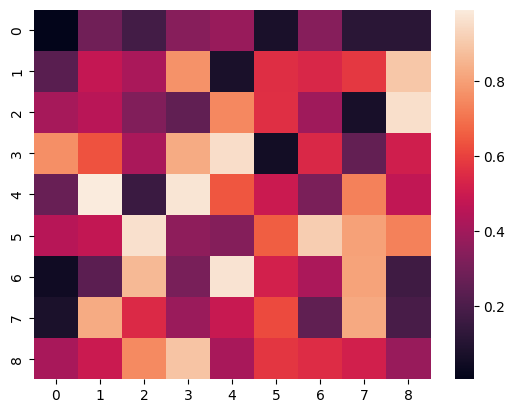

In [26]:
if __name__=="__main__":
    n = 9
    m = 9
    b = 100000
    v = np.random.rand(n, m)

    ws = WelfareSolver(n, m, b, v)
    sns.heatmap(v)
    ws.execute()